<a href="https://colab.research.google.com/github/MarcAtanante/ai-for-fun/blob/main/01b%20-%20Finetuning_Distilbert_on_banking77.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bonus points: Use another text classification dataset to perform fine-tuning

# Fine-tuning a sentiment classifier with your own data
### [Credits to Argilla.io for the Documentation](https://docs.argilla.io/en/latest/tutorials/notebooks/training-textclassification-transformers-pretrained.html?fbclid=IwAR0Dqmb6yKfsYtpn2V-iMDQUZ3784QQ3791OHa1sTMUn9oqsKFFSvbGYM-4)

1. Pre-trained model: [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
2. Dataset: [banking77](https://huggingface.co/datasets/banking77)
- This dataset contains online banking user queries annotated with their corresponding intents.
- In our case, we’ll label the sentiment of these queries. This might be useful for digital assistants and customer service analytics.

## Approach:
🏁 The distilbert model is fine-tuned on SST-2 (Stanford Sentiment Treebank), a highly popular sentiment classification benchmark. As we will see later, this is a general-purpose sentiment classifier, which will need further fine-tuning for specific use cases and styles of text. In our case, we’ll explore its quality on banking user queries and build a training set for adapting it to this domain.

🏷️ Label a training dataset with banking user requests starting with the pre-trained sentiment classifier predictions.

⚙️ Fine-tune the pre-trained classifier with your training dataset.

🏷️ Label more data by correcting the predictions of the fine-tuned model.

⚙️ Fine-tune the pre-trained classifier with the extended training dataset.


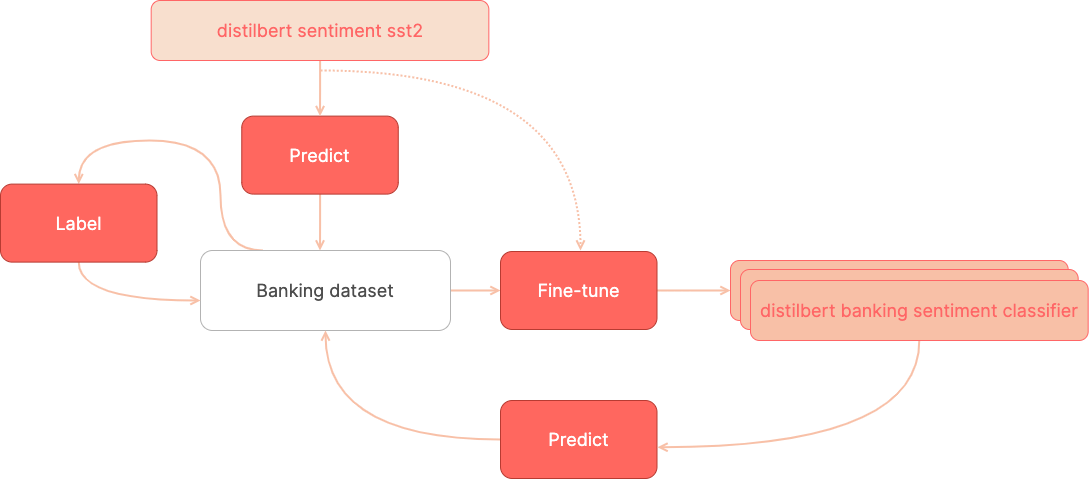

## Deployed Argilla on Hugging Face Spaces: [marcatanante1/ai-for-fun](https://huggingface.co/spaces/marcatanante1/ai-for-fun)

In [ ]:
! pip install argilla "transformers[torch]" datasets sklearn ipywidgets -qqq

In [2]:
import argilla as rg

In [3]:
# Initialization
rg.init(
    api_url = "https://marcatanante1-ai-for-fun.hf.space",
    api_key = "argilla.apikey"
)

In [4]:
# Import necessary packages
import numpy as np

from datasets import load_dataset, load_metric, concatenate_datasets

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

Load the dataset directly from the hub and split the dataset into two 50% subsets. We’ll start with the to_label1 split for data exploration and annotation, and keep to_label2 for further iterations.

In [5]:
# Loading the dataset from hub
banking_ds = load_dataset("banking77")

to_label1, to_label2 = (
    banking_ds["train"].train_test_split(test_size = 0.5, seed = 42).values()
)

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Loading the model

In [6]:
sentiment_classifier = pipeline(
    model = "distilbert-base-uncased-finetuned-sst-2-english",
    task = "sentiment-analysis",
    return_all_scores = True,
)

# Display an example
to_label1[3]["text"], sentiment_classifier(to_label1[3]["text"])

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


('Hi, Last week I have contacted the seller for a refund as directed by you, but i have not received the money yet. Please look into this issue with seller and help me in getting the refund.',
 [[{'label': 'NEGATIVE', 'score': 0.9934700727462769},
   {'label': 'POSITIVE', 'score': 0.006529900711029768}]])

- The model assigns more probability to the NEGATIVE class. Following our annotation policy (read more below), we’ll label examples like this as POSITIVE as they are general questions, not related to issues or problems with the banking application. The ultimate goal will be to fine-tune the model to predict POSITIVE for these cases.

- Sentiment analysis is one of the most subjective tasks in NLP. What we understand by sentiment will vary from one application to another and depend on the business objectives of the project. Also, sentiment can be modeled in different ways, leading to different labeling schemes. For example, sentiment can be modeled as real value (going from -1 to 1, from 0 to 1.0, etc.) or with 2 or more labels (including different degrees such as positive, negative, neutral, etc.)

- For this tutorial, we’ll use the original labeling scheme defined by the pre-trained model which is composed of two labels: POSITIVE and NEGATIVE. We could have added the NEUTRAL label, but let’s keep it simple.

- Another important issue when approaching a data annotation project are the annotation guidelines, which explain how to assign the labels to specific examples. As we’ll see later, the messages we’ll be labeling are mostly questions with a neutral sentiment, which we’ll label with the POSITIVE label, and some other are negative questions which we’ll label with the NEGATIVE label. Later on, we’ll show some examples of each label.

### Run the pre-trained model over the dataset and log the predictions
- As a first step, let’s use the pre-trained model for predicting over our raw dataset. 

In [7]:
def predict(examples):
    return {"predictions": sentiment_classifier(examples["text"], truncation=True)}

# add .select(range(10)) before map if you just want to test this quickly with 10 examples
to_label1 = to_label1.map(predict, batched=True, batch_size=4)

Map:   0%|          | 0/5001 [00:00<?, ? examples/s]

### Build and log dataset
- The following code builds a list of Argilla records with the predictions and log the records to Argilla to label our first training set.

In [9]:
records = []
for example in to_label1.shuffle():
    record = rg.TextClassificationRecord(
        text=example["text"],
        metadata={
            "category": example["label"]
        },  # log the intents for exploration of specific intents
        prediction=[(pred["label"], pred["score"]) for pred in example["predictions"]],
        prediction_agent="distilbert-base-uncased-finetuned-sst-2-english",
    )
    records.append(record)

rg.log(name = "labeling_with_pretrained", records = records )

  0%|          | 0/5001 [00:00<?, ?it/s]

5001 records logged to https://marcatanante1-ai-for-fun.hf.space/datasets/argilla/labeling_with_pretrained


BulkResponse(dataset='labeling_with_pretrained', processed=5001, failed=0)

In [17]:
records[5]

TextClassificationRecord(text="My payment didn't work and the money is in back in my account.", inputs={'text': "My payment didn't work and the money is in back in my account."}, prediction=[('NEGATIVE', 0.9993656277656555), ('POSITIVE', 0.000634389987681061)], prediction_agent='distilbert-base-uncased-finetuned-sst-2-english', annotation=None, annotation_agent=None, vectors=None, multi_label=False, explanation=None, id=None, metadata={'category': 53}, status='Default', event_timestamp=datetime.datetime(2023, 3, 7, 10, 26, 32, 505566), metrics=None, search_keywords=None)

### Explore and label data with the pretrained model

In this step, we’ll start by exploring how the pre-trained model is performing with our dataset.

At first sight:

- The pre-trained sentiment classifier tends to label most of the examples as NEGATIVE (4.835 of 5.001 records). You can see this yourself using the Predictions / Predicted as: filter

- Using this filter and filtering by predicted as POSITIVE, we see that examples like “I didn’t withdraw the amount of cash that is showing up in the app.” are not predicted as expected (according to our basic “annotation policy” described in the preliminaries).

Taking into account this analysis, we can start labeling our data.

Argilla provides you with a search-driven UI to annotated data, using free-text search, search filters and the Elasticsearch query DSL for advanced queries. This is especially useful for sparse datasets, tasks with a high number of labels, or unbalanced classes. In the standard case, we recommend you to follow the workflow below:

1. Start labeling examples sequentially, without using search features. This way you will annotate a fraction of your data which will be aligned with the dataset distribution.

2. Once you have a sense of the data, you can start using filters and search features to annotate examples with specific labels. In our case, we’ll label examples predicted as POSITIVE by our pre-trained model, and then a few examples predicted as NEGATIVE.

Distribution of Labels:
True Positives: 69
False Negatives: 40

True Negatives: 95
False Positives: 31

Ratio is 126:126, this will be used for fine-tuning.

### Fine-tune the pre-trained model
In this step, we’ll load our training set from Argilla and fine-tune using the Trainer API from Hugging Face transformers. For this, we closely follow the guide Fine-tuning a pre-trained model from the transformers docs.

First, let’s load the annotations from our dataset using the query parameter from the load method. The Validated status corresponds to annotated records.

In [18]:
rb_dataset = rg.load(name="labeling_with_pretrained", query="status:Validated")
rb_dataset.to_pandas().head(3)

,text,inputs,prediction,prediction_agent,annotation,annotation_agent,vectors,multi_label,explanation,id,metadata,status,event_timestamp,metrics,search_keywords
0,What steps do I need to take to exchange curre...,{'text': 'What steps do I need to take to exch...,"[(NEGATIVE, 0.9883080124855042), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,argilla,None,False,None,00014f7e-d7a6-4a17-9a60-c8bfbb0f06ad,{'category': 33},Validated,2023-03-07 10:26:36.527693,{'text_length': 52},None
1,My card has been lost / stolen,{'text': 'My card has been lost / stolen'},"[(NEGATIVE, 0.9974241256713867), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,NEGATIVE,argilla,None,False,None,00106b70-03d1-4f50-91b2-2d154ea7ba9f,{'category': 41},Validated,2023-03-07 10:26:34.151002,{'text_length': 30},None
2,Where do I go to edit my personal details on m...,{'text': 'Where do I go to edit my personal de...,"[(NEGATIVE, 0.9993594288825989), (POSITIVE, 0....",distilbert-base-uncased-finetuned-sst-2-english,POSITIVE,argilla,None,False,None,00176bad-3b30-4120-a46f-1763ab88a13f,{'category': 30},Validated,2023-03-07 10:26:34.112683,{'text_length': 56},None


In [21]:
rb_dataset.to_pandas().shape

(252, 15)

### Prepare training and test datasets
Let’s now prepare our dataset for training and testing our sentiment classifier, using the datasets library:

In [22]:
# create 🤗 dataset with labels as numeric ids
train_ds = rb_dataset.prepare_for_training()

# tokenize our datasets
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_ds = train_ds.map(tokenize_function, batched=True)

# split the data into a training and evaluation set
train_dataset, eval_dataset = tokenized_train_ds.train_test_split(
    test_size=0.2, seed=42
).values()

Map:   0%|          | 0/252 [00:00<?, ? examples/s]

### Train our sentiment classifier
As we mentioned before, we’re going to fine-tune the distilbert-base-uncased-finetuned-sst-2-english model.

Let’s load the model and configure the trainer:

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

training_args = TrainingArguments(
    "distilbert-base-uncased-sentiment-banking",
    evaluation_strategy="epoch",
    logging_steps=30,
)

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

<ipython-input-23-edd6a6050cde>:11: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [24]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 201
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78
  Number of trainable parameters = 66955010


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.177916,0.921569
2,0.476700,0.141194,0.941176
3,0.053700,0.183843,0.941176


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 51
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 51
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 51
  B

TrainOutput(global_step=78, training_loss=0.2043095003001583, metrics={'train_runtime': 32.3462, 'train_samples_per_second': 18.642, 'train_steps_per_second': 2.411, 'total_flos': 79877841389568.0, 'train_loss': 0.2043095003001583, 'epoch': 3.0})

### Testing the fine-tuned model
In this step, let’s first test the model we have just trained.

Let’s create a new pipeline with our model:

In [25]:
finetuned_sentiment_classifier = pipeline(
    model=model.to("cpu"),
    tokenizer=tokenizer,
    task="sentiment-analysis",
    return_all_scores=True,
)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Then, we can compare its predictions with the pre-trained model and an example:

In [26]:
finetuned_sentiment_classifier(
    "I need to deposit my virtual card, how do i do that."
), sentiment_classifier("I need to deposit my virtual card, how do i do that.")

([[{'label': 'NEGATIVE', 'score': 0.0003902378084603697},
   {'label': 'POSITIVE', 'score': 0.9996097683906555}]],
 [[{'label': 'NEGATIVE', 'score': 0.9992493987083435},
   {'label': 'POSITIVE', 'score': 0.0007506068213842809}]])

As you can see, our fine-tuned model now classifies this general questions (not related to issues or problems) as POSITIVE, while the pre-trained model still classifies this as NEGATIVE.

Let’s check now an example related to an issue where both models work as expected:

In [27]:
finetuned_sentiment_classifier(
    "Why is my payment still pending?"
), sentiment_classifier("Why is my payment still pending?")

([[{'label': 'NEGATIVE', 'score': 0.9996121525764465},
   {'label': 'POSITIVE', 'score': 0.0003878741408698261}]],
 [[{'label': 'NEGATIVE', 'score': 0.9983781576156616},
   {'label': 'POSITIVE', 'score': 0.00162184564396739}]])

## Summary
In this tutorial, you learned how to build a training set from scratch with the help of a pre-trained model, performing an iteration of predict > log > label.

Although this is somehow a toy example, you will be able to apply this workflow to your own projects to adapt existing models or building them from scratch.

In this tutorial, we’ve covered one way of building training sets: hand labeling. 